<a href="https://www.kaggle.com/code/aggarwalmanish/ai-training-hybrid-models?scriptVersionId=185565898" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Problem Statement

We have been given a PDE
$$ \frac{\partial u}{\partial x} = 2\frac{\partial u}{\partial t}+u$$
and boundary condition: 
$$u(x,0)=6e^{-3x}$$

We want to find out $u(x,t)$ for all $x$ in range $[0.5,2.5]$ and $t$ in range $[0,1]$.

When we solved this problem analytically, we found the solution
$$u(x,t) = 6e^{-3x-2t}$$

In this exercise, we are going to use a Physics Informed Neural Network (PINN) to solve this PDE. PINN uses classic neural network structure, but adds a physics-informed loss to the loss function that's optimized during training. This exercise has some blank spaces that need to be completed. These lines are marked with "EXCR". A complete version is also available in this excercise package. The picture below shows general structure of PINN.

In this example, the physics-informed loss is $f = \frac{\partial u}{\partial x} - 2\frac{\partial u}{\partial t} - u$

To show how physics help extrapolation, we train the PINN with extrapolated inputs. Specifically, $x$ extrapolates to $[0,3]$, $t$ extrapolates to $[0,1.5]$.

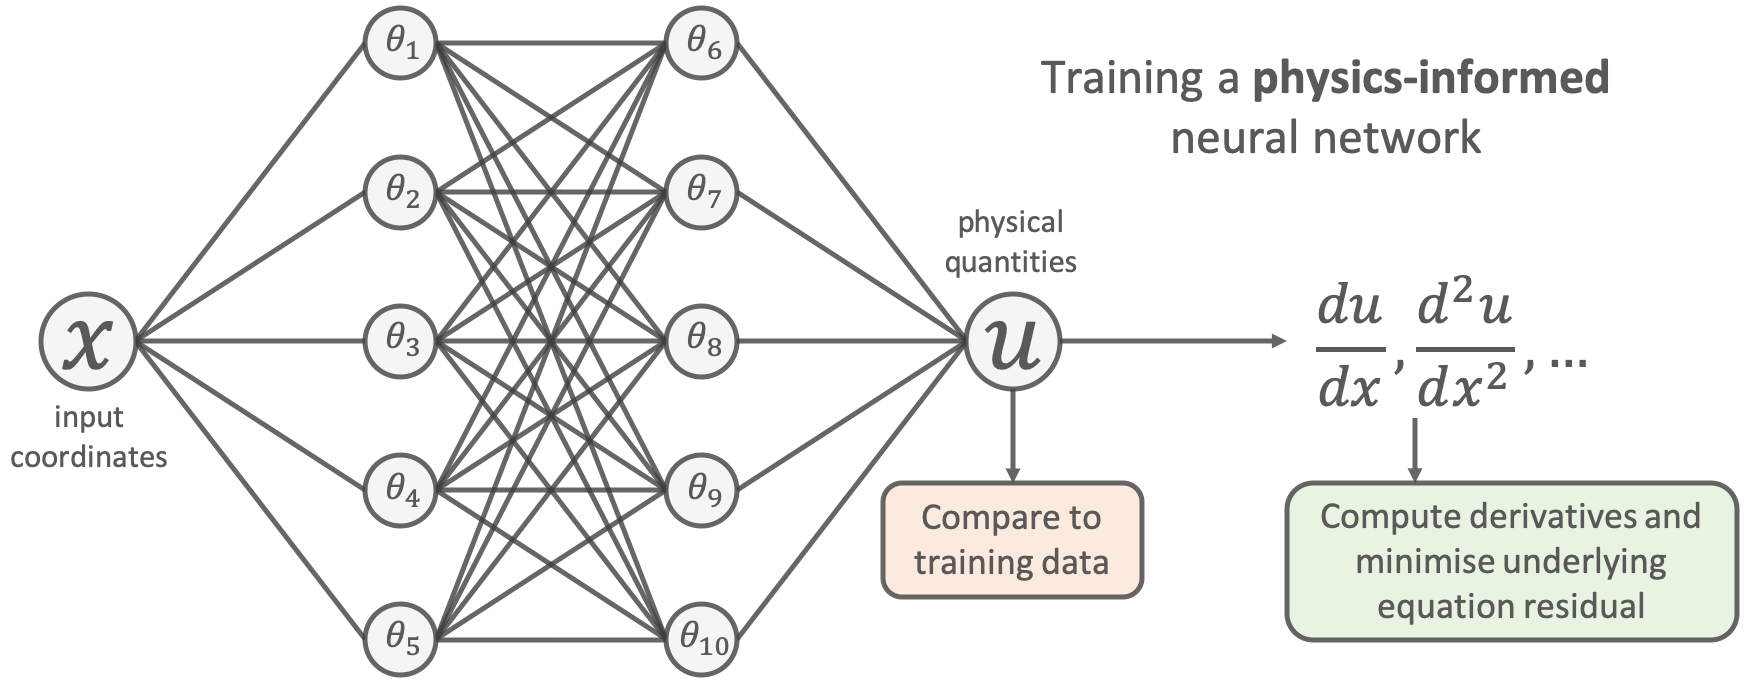

In [1]:
from IPython.display import Image
Image("/kaggle/input/pinn-structure/PINN_structure.PNG")

# 1. Install/Import Libraries and Utility Functions

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import numpy as np

# 2. Model Building and Training

#### <font color='blue'>Task #1. Define hidden layer 3, a linear layer with 5 output neurons.</font>
#### <font color='blue'>Task #2. Define hidden layer 4, a linear layer with 5 output neurons.</font>
#### <font color='blue'>Task #3. Calculate layer3_out in the way that layer2_out is calculated.</font>
#### <font color='blue'>Task #4. calculate layer4_out in the way that layer2_out is calculated.</font>

In [3]:
# We consider Net as our solution u_theta(x,t)

"""
When forming the network, we have to keep in mind the number of inputs and outputs
In this case: #inputs = 2 (x,t)
and #outputs = 1

You can add as many hidden layers as you want with as many neurons.
More complex the network, the more prepared it is to find complex solutions, but it also requires more data.

Let us create this network:
5 hidden layer with 5 neurons each.
"""

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2,5)
        self.hidden_layer2 = nn.Linear(5,5)
        self.hidden_layer3 = nn.Linear(5,5) # EXCR: Define hidden layer 3, a linear layer with 5 output neurons
        self.hidden_layer4 = nn.Linear(5,5) # EXCR: Define hidden layer 4, a linear layer with 5 output neurons
        self.hidden_layer5 = nn.Linear(5,5)
        self.output_layer = nn.Linear(5,1)

    def forward(self, x,t):
        inputs = torch.cat([x,t],axis=1) # combined two arrays of 1 columns each to one array of 2 columns
        layer1_out = torch.sigmoid(self.hidden_layer1(inputs))
        layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer2(layer2_out))# EXCR: calculate layer3_out in the way that layer2_out is calculated
        layer4_out = torch.sigmoid(self.hidden_layer2(layer3_out)) # EXCR: calculate layer4_out in the way that layer2_out is calculated
        layer5_out = torch.sigmoid(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out) ## For regression, no activation is used in output layer
        return output

#### <font color='blue'>Task #5. Call the mean squared error loss function in torch.nn.</font>
#### <font color='blue'>Task #6. Pass net parameters to Adam optimizer.</font>

In [4]:
### Model
net = Net()
net = net.to(device)
mse_cost_function = torch.nn.MSELoss() # EXCR: Call the mean squared error loss function in torch.nn
optimizer = torch.optim.Adam(net.parameters()) # EXCR: Pass net parameters to Adam optimizer

#### <font color='blue'>Task #7. Define PDE loss as ∂u/∂x - 2∂u/∂t - u.</font>

In [5]:
## PDE as loss function. Thus would use the network which we call as u_theta
def f(x,t, net):
    u = net(x,t) # the dependent variable u is given by the network based on independent variables x,t
    ## Based on our f = ∂u/∂x - 2∂u/∂t - u, we need ∂u/∂x and ∂u/∂t
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    pde = u_x - 2 * u_t - u # EXCR: Define PDE loss as ∂u/∂x - 2∂u/∂t - u
    return pde

#### <font color='blue'>Task #8. Calculate u_bc based on u(x,0)=6e^(-3x).</font>
#### <font color='blue'>Task #9. Define pt_u_bc in the way that pt_t_bc is defined.</font>

In [6]:
## Data from Boundary Conditions
# u(x,0)=6e^(-3x)
# In PINN, BC gives us datapoints for training. To show how incorporating physics improves extrapolation, We use extrapolated range for
# x and t, that is, [0,3] for x and [0,1.5] for t.

# BC tells us that for any x in range[0,3] and time=0, the value of u is given by 6e^(-3x)
# Take 100 random numbers of x
data_size = 100
x_bc = np.random.uniform(low=0, high=3, size=(data_size,1))
t_bc = np.zeros((data_size,1))
# compute u based on BC
u_bc = 6 * np.exp(-3 * x_bc) # EXCR: Calculate u_bc based on u(x,0)=6e^(-3x)

pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
pt_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device) # EXCR: Define pt_u_bc in the way that pt_t_bc is defined

x_collocation = np.random.uniform(low=0.0, high=2.0, size=(500,1))
t_collocation = np.random.uniform(low=0.0, high=1.0, size=(500,1))
all_zeros = np.zeros((500,1))

pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True).to(device)
pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)

#### <font color='blue'>Task #10. Pass pt_x_bc and pt_t_bc to calculate model output at boundary.</font>
#### <font color='blue'>Task #11. Pass net_bc_out and pt_u_bc to calculate mean squared error at boundary.</font>
#### <font color='blue'>Task #12. Pass pt_x_collocation, pt_t_collocation, and the model to calculate PDE loss.</font>

In [7]:
### Training / Fitting
iterations = 20000
for epoch in range(iterations):
    
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on boundary conditions
    net_bc_out = net(pt_x_bc, pt_t_bc) # EXCR: Pass pt_x_bc and pt_t_bc to calculate model output at boundary
    mse_u = mse_cost_function(net_bc_out, pt_u_bc) # EXCR: Pass net_bc_out and pt_u_bc to calculate mean squared error at boundary
    
    # Loss based on PDE
    f_out = f(pt_x_collocation, pt_t_collocation, net) # EXCR: Pass pt_x_collocation, pt_t_collocation, and the model to calculate PDE loss
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = mse_u + mse_f
    
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # This is equivalent to: theta_new = theta_old - alpha * derivative of loss w.r.t theta
    
    with torch.autograd.no_grad():
        if epoch % 1000 == 0 or epoch == iterations-1:
        	print("Iteration", epoch, ", Traning Loss:", loss.data)

Iteration 0 , Traning Loss: tensor(2.0997)
Iteration 1000 , Traning Loss: tensor(1.7733)
Iteration 2000 , Traning Loss: tensor(0.0948)
Iteration 3000 , Traning Loss: tensor(0.0166)
Iteration 4000 , Traning Loss: tensor(0.0043)
Iteration 5000 , Traning Loss: tensor(0.0013)
Iteration 6000 , Traning Loss: tensor(0.0004)
Iteration 7000 , Traning Loss: tensor(0.0001)
Iteration 8000 , Traning Loss: tensor(4.1580e-05)
Iteration 9000 , Traning Loss: tensor(1.6366e-05)
Iteration 10000 , Traning Loss: tensor(1.3230e-05)
Iteration 11000 , Traning Loss: tensor(8.5396e-06)
Iteration 12000 , Traning Loss: tensor(7.4352e-06)
Iteration 13000 , Traning Loss: tensor(6.4132e-06)
Iteration 14000 , Traning Loss: tensor(5.5674e-06)
Iteration 15000 , Traning Loss: tensor(5.1167e-06)
Iteration 16000 , Traning Loss: tensor(4.7380e-06)
Iteration 17000 , Traning Loss: tensor(5.2343e-06)
Iteration 18000 , Traning Loss: tensor(4.1368e-06)
Iteration 19000 , Traning Loss: tensor(4.0318e-06)
Iteration 19999 , Traning

#### Compare against training a neural network with 100 samples from the truth function $u(x,t) = 6e^{-3x-2t}$. In this scenario, the range for $x$ and $t$ are $[0.5,2.5]$ and $[0,1]$ respectively.

In [8]:
### Plain neural network model
net_plain = Net()
net_plain = net_plain.to(device)
optimizer = torch.optim.Adam(net_plain.parameters())

### Sample values from truth function 6e^(-3x-2t)
x_t_arr = np.random.uniform(low=(0.5, 0.), high=(2.5, 1.), size=(data_size, 2))
u_truth = 6*np.exp(-3*x_t_arr[:,0]-2*x_t_arr[:,1]).reshape(-1,1)
pt_x = Variable(torch.from_numpy(x_t_arr[:,[0]]).float(), requires_grad=False).to(device)
pt_t = Variable(torch.from_numpy(x_t_arr[:,[1]]).float(), requires_grad=False).to(device)
pt_u = Variable(torch.from_numpy(u_truth).float(), requires_grad=False).to(device)

### Training / Fitting
iterations = 20000
for epoch in range(iterations):
    optimizer.zero_grad()
    net_plain_out = net_plain(pt_x, pt_t)
    loss = mse_cost_function(net_plain_out, pt_u)
    loss.backward()
    optimizer.step()
    with torch.autograd.no_grad():
        if epoch % 1000 == 0 or epoch == iterations-1:
        	print("Iteration", epoch, ", Traning Loss:", loss.data)

Iteration 0 , Traning Loss: tensor(0.2042)
Iteration 1000 , Traning Loss: tensor(0.0306)
Iteration 2000 , Traning Loss: tensor(0.0306)
Iteration 3000 , Traning Loss: tensor(0.0226)
Iteration 4000 , Traning Loss: tensor(5.6113e-05)
Iteration 5000 , Traning Loss: tensor(1.5197e-05)
Iteration 6000 , Traning Loss: tensor(8.2375e-06)
Iteration 7000 , Traning Loss: tensor(4.6363e-06)
Iteration 8000 , Traning Loss: tensor(2.4071e-06)
Iteration 9000 , Traning Loss: tensor(1.1652e-06)
Iteration 10000 , Traning Loss: tensor(5.5247e-07)
Iteration 11000 , Traning Loss: tensor(2.7348e-07)
Iteration 12000 , Traning Loss: tensor(1.5838e-07)
Iteration 13000 , Traning Loss: tensor(1.0821e-07)
Iteration 14000 , Traning Loss: tensor(7.9600e-08)
Iteration 15000 , Traning Loss: tensor(6.1897e-08)
Iteration 16000 , Traning Loss: tensor(3.6754e-07)
Iteration 17000 , Traning Loss: tensor(3.9698e-08)
Iteration 18000 , Traning Loss: tensor(3.2544e-08)
Iteration 19000 , Traning Loss: tensor(6.4223e-07)
Iteration

In [9]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
 
def get_facecolor(self):
    if not hasattr(self, '_facecolors2d'):
        self.axes.M = self.axes.get_proj()
        self.do_3d_projection()
    return np.asarray(self._facecolors2d)
 
def get_edgecolor(self):
    if not hasattr(self, '_edgecolors2d'):
        self.axes.M = self.axes.get_proj()
        self.do_3d_projection()
    return np.asarray(self._edgecolors2d)
 
Poly3DCollection.get_facecolor = get_facecolor
Poly3DCollection.get_edgecolor = get_edgecolor

In [10]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
 
def get_facecolor(self):
    if not hasattr(self, '_facecolors2d'):
        self.axes.M = self.axes.get_proj()
        self.do_3d_projection()
    return np.asarray(self._facecolors2d)
 
def get_edgecolor(self):
    if not hasattr(self, '_edgecolors2d'):
        self.axes.M = self.axes.get_proj()
        self.do_3d_projection()
    return np.asarray(self._edgecolors2d)
 
Poly3DCollection.get_facecolor = get_facecolor
Poly3DCollection.get_edgecolor = get_edgecolor

# 3. Model Evaluation

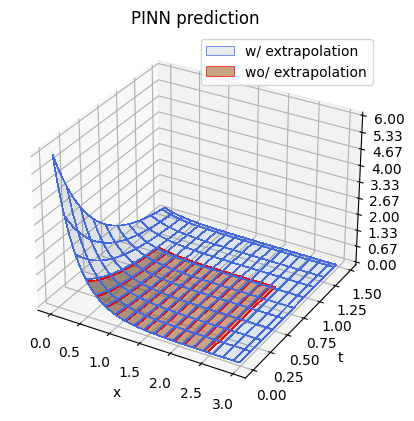

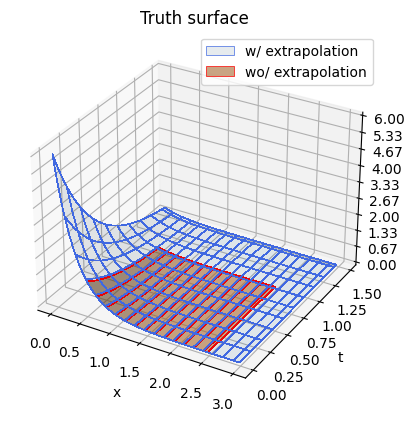

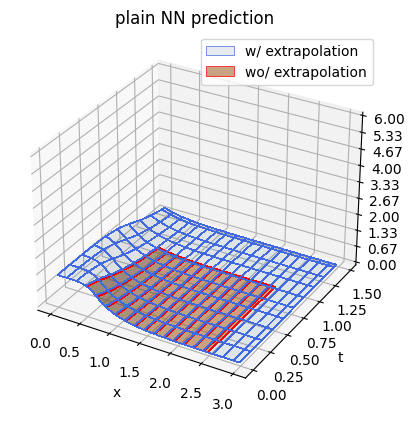

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

def plot_surface(ms_x, ms_t, ms_u, ms_x_ext, ms_t_ext, ms_u_ext, title):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    surf_ext = ax.plot_surface(
        ms_x_ext, ms_t_ext, ms_u_ext, edgecolor='royalblue', antialiased=False, label="w/ extrapolation",
        lw=0.5, rstride=8, cstride=8, alpha=0.1
    )
    surf = ax.plot_surface(
        ms_x, ms_t, ms_u, edgecolor='red', linewidth=0, antialiased=False, label="wo/ extrapolation",
        lw=0.5, rstride=8, cstride=8, alpha=0.5
    )
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    plt.legend()
    plt.title(title)
    ax.set_xlabel("x"); ax.set_ylabel("t")
    ax.set_zlim(0.0, 6.0)
    plt.show()

# x and t with and without extrapolation
x, t = np.arange(0.5, 2.5, 0.02), np.arange(0.0, 1.0, 0.02)
x_ext, t_ext = np.arange(0.0, 3.0, 0.02), np.arange(0.0, 1.5, 0.02)
ms_x, ms_t = np.meshgrid(x, t)
ms_x_ext, ms_t_ext = np.meshgrid(x_ext, t_ext)

# PINN prediction. Just because meshgrid is used, we need to do the following adjustment
x, t = np.ravel(ms_x).reshape(-1,1), np.ravel(ms_t).reshape(-1,1)
x_ext, t_ext = np.ravel(ms_x_ext).reshape(-1,1), np.ravel(ms_t_ext).reshape(-1,1)
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
pt_x_ext = Variable(torch.from_numpy(x_ext).float(), requires_grad=True).to(device)
pt_t_ext = Variable(torch.from_numpy(t_ext).float(), requires_grad=True).to(device)

pt_u = net(pt_x,pt_t)
u = pt_u.data.cpu().numpy()
ms_u_pred = u.reshape(ms_x.shape)
pt_u_ext = net(pt_x_ext, pt_t_ext)
u_ext = pt_u_ext.data.cpu().numpy()
ms_u_pred_ext = u_ext.reshape(ms_x_ext.shape)
plot_surface(ms_x, ms_t, ms_u_pred, ms_x_ext, ms_t_ext, ms_u_pred_ext, title="PINN prediction")

# Plot truth surface
ms_u_truth = 6*np.exp(-3*ms_x-2*ms_t)
ms_u_truth_ext = 6*np.exp(-3*ms_x_ext-2*ms_t_ext)
plot_surface(ms_x, ms_t, ms_u_truth, ms_x_ext, ms_t_ext, ms_u_truth_ext, title="Truth surface")

# Plot surface from a plain neural network
pt_u_plain = net_plain(pt_x,pt_t)
u_plain = pt_u_plain.data.cpu().numpy()
ms_u_plain_pred = u_plain.reshape(ms_x.shape)
pt_u_plain_ext = net_plain(pt_x_ext, pt_t_ext)
u_plain_ext = pt_u_plain_ext.data.cpu().numpy()
ms_u_plain_pred_ext = u_plain_ext.reshape(ms_x_ext.shape)
plot_surface(ms_x, ms_t, ms_u_plain_pred, ms_x_ext, ms_t_ext, ms_u_plain_pred_ext, title="plain NN prediction")